In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SchwiftyNotebook_convolution_model")' SchwiftyNotebook_convolution_model

Installing packages:
	.package(path: "/home/ubuntu/workspace/fast-ai-swift/SchwiftyNotebook_convolution_model")
		SchwiftyNotebook_convolution_model
With SwiftPM flags: []
Working in: /tmp/tmpw9qnwjgm/swift-install
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version info

In [2]:
//export
import Path
import TensorFlow
import SchwiftyNotebook_convolution_model

In [3]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

public let plotter = Python.import("matplotlib.pyplot")

# Data Setup

In [4]:
let n = 100
let inputPoints = TensorFloat(randomNormal: [100, 1])
let A = inputPoints.concatenated(with: TensorFloat(ones: inputPoints.shape), alongAxis: 1)
A.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [5]:
let yValidationPoints = matmul(A, TensorFloat([-2, 7]).expandingShape(at: 1)) + 
                (TensorFloat(randomNormal: inputPoints.shape, seed: (69, 420)) * 2.5)
yValidationPoints.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


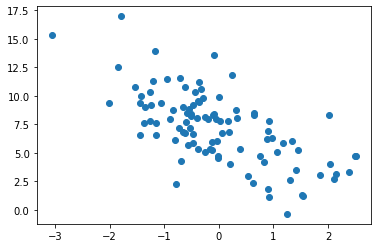

None


In [6]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
plotter.show()

# Model Creation

In [7]:
@differentiable
func squareBoi(inputTensor: TensorFloat) -> TensorFloat {
    return inputTensor * inputTensor
}

let (squared, squareGradientChain) = valueWithPullback(at: TensorFloat([2, 3]), in: squareBoi)
print(squared)
print(type(of: squareGradientChain))

[4.0, 9.0]
(Tensor<Float>) -> Tensor<Float>


In [8]:
//tail recursion?
func loopyBoi(x: Int) {
    guard x > 0 else { return }
    print("Loopy Boi \(x)")
    return loopyBoi(x: x - 1)
}

loopyBoi(x: 5)

Loopy Boi 5
Loopy Boi 4
Loopy Boi 3
Loopy Boi 2
Loopy Boi 1


In [9]:
let tensorBoi = TensorFloat([1, 2, 3]).expandingShape(at: 1)
let weightParameter = TensorFloat(kaimingUniform: TensorShape([2, 1]))
let biasParameter = TensorFloat(zeros: [1])

In [11]:
//export 
public func denseLayerCombination(inputTensor: TensorFloat, 
                     weightParameter: TensorFloat, 
                     biasParameter: TensorFloat) -> TensorFloat {
    return matmul(inputTensor, weightParameter) + biasParameter
}

@differentiating(denseLayerCombination)
public func denseLayerCombinationGradient(inputParameter: TensorFloat, 
                        weightParameter: TensorFloat, 
                        biasParameter: TensorFloat) -> (value: TensorFloat, 
                                                        pullback: (TensorFloat) -> 
                                                        (TensorFloat, TensorFloat, TensorFloat)) {
    //M x N * N x O = M x O
    return (value: denseLayerCombination(inputTensor: inputParameter, 
                                   weightParameter: weightParameter, 
                                   biasParameter: biasParameter), 
            pullback: { ddx in (
                            inputParameter,
                            matmul(inputParameter.transposed(), ddx),
                            ddx.unbroadcasted(to: biasParameter.shape)) 
                          }
           )
}

In [12]:
let (womboCombo, womboComboGradientChain) = valueWithPullback(at: A, 
                                                              weightParameter, 
                                                              biasParameter, 
                                                              in: denseLayerCombination)

In [13]:
func showYHat(yHat: TensorFloat) {
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yValidationPoints.makeNumpyArray())
    plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
    plotter.show()
}

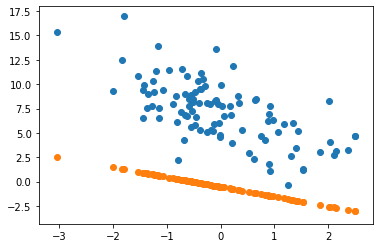

In [14]:
//first guess
showYHat(yHat: matmul(A, weightParameter))

In [15]:
let (activations, activationChain) = linearCombinationAndGradient(inputTensor: A, 
                                                                  weightParameter: weightParameter, 
                                                                  biasParameter: biasParameter)
let error = activations - yValidationPoints
let (squareValue, squareGradient) = squaredWithGradient(inputTensor: error)
let (meanValue, meanGradient) = meanWithGradient(inputTensor: squareValue)

// Time to go backward bois!
let ddxMean = meanGradient(TensorFloat([1]))
let ddxSquare = squareGradient(ddxMean)
let (ddxInput, ddxWeightParam, ddxBias) = activationChain(ddxSquare)

In [16]:
let (autoActivations, autoActivationChain) = valueWithPullback(at: A, 
                                                              weightParameter, 
                                                              biasParameter, 
                                                              in: denseLayerCombination)
assertEquals(activations, autoActivations, "Expected Auto Activations to be the same as mine")
let (_, autoDdxWeightParam, autoDdxBias) = autoActivationChain(ddxSquare)
assertEquals(autoDdxWeightParam, ddxWeightParam, "Expected weight gradient to be the same")
assertEquals(autoDdxBias, ddxBias, "Expected bias gradient to be the same")

In [17]:
//export
@differentiable
public func squaredTensor(inputTensor: TensorFloat) -> TensorFloat {
    return inputTensor * inputTensor
}

In [18]:
let (autoSquare, autoSquareChain) = valueWithPullback(at: error, in: squaredTensor)
assertEquals(autoSquare, squareValue, "Expecte Auto Square to equal my square")
assertEquals(ddxSquare, autoSquareChain(ddxMean), "Expected auto square gradient to equal my gradient")

In [19]:
//export
@differentiable
public func meanOfTensor(inputTensor: TensorFloat) -> TensorFloat {
    return inputTensor.mean()
}

In [32]:
let (autoMean, autoMeanChain) = valueWithPullback(at: squareValue, in:meanOfTensor)
assertEquals(autoMean, meanValue, "Expected auto mean to be equal to my mean.")
let autoMeanGraident = autoMeanChain(TensorFloat(1))
assertEquals(autoMeanGraident, ddxMean.broadcasted(to: autoMeanGraident.shape), "Expected auto mean gradient to be equal to mine")

In [33]:
//export
@differentiable
public func squaredMeanOfTensor(inputTensor: TensorFloat) -> TensorFloat {
    return meanOfTensor(inputTensor: squaredTensor(inputTensor: inputTensor))
}

In [38]:
let (autoSquaredMean, autoSquaredMeanChain) = valueWithPullback(at: error, in: squaredMeanOfTensor)
assertEquals(meanValue, autoSquaredMean, "Expected my mean to be equal to auto mean")
let ddxAutoMean = autoSquaredMeanChain(TensorFloat(1))
assertEquals(ddxAutoMean, ddxMean.broadcasted(to: ddxAutoMean.shape), "Expected auto mean to equal my mean")

In [52]:
public func meanSquaredErrorOfTensor(yHat: TensorFloat, y: TensorFloat) -> TensorFloat{
    return squaredMeanOfTensor(inputTensor: yHat - y)
}

@differentiating(meanSquaredErrorOfTensor)
public func meanSquaredErrorOfTensorGradient(yHat: TensorFloat, y: TensorFloat) -> (value: TensorFloat, 
                                                                                    pullback: (TensorFloat) -> (TensorFloat, TensorFloat)) {
    let error = yHat - y
    let (mse, ddxMSE) = valueWithPullback(at: error, in: squaredMeanOfTensor)
    return (value: mse, pullback: { ddx in 
                                     let mseGrad = ddxMSE(ddx)
                                     return (mseGrad, mseGrad)
                                  } )
}

In [53]:
let (autoMSE, autoMSEChain) = valueWithPullback(at: activations, yValidationPoints, in: meanSquaredErrorOfTensor)
assertEquals(autoMSE, meanValue, "Expected auto mse to be equal to my MSE")
let (ddxMSE, _) = autoMSEChain(TensorFloat(1))
assertEquals(ddxMSE, ddxMean.broadcasted(to: ddxMSE.shape), "Expected auto mse gradent to be equal to mine")

In [65]:
//export
public func leakyReLU(inputTensor: TensorFloat,
                                           negativeSlope: Float) -> TensorFloat {
    return max(0, inputTensor) + negativeSlope * min(0, inputTensor)
}

@differentiating(leakyReLU)
public func leakyReLUGradient(inputTensor: TensorFloat, 
                              negativeSlope: Float = 0.0) -> (value: TensorFloat, 
                                                               pullback: (TensorFloat) -> 
                                                                       (TensorFloat, Float)) {
    let leakyActivations = leakyReLU(inputTensor: inputTensor, negativeSlope: negativeSlope)
    return (value: leakyActivations, 
            pullback: { (ddx: TensorFloat) in (ddx.unbroadcasted(to: inputTensor.shape), negativeSlope)})
}

In [66]:
var weightParameter = TensorFloat([5, 3]).expandingShape(at: 1)
let learningRate: Float = 5e-2
var biasParameter = TensorFloat(zeros: [1])

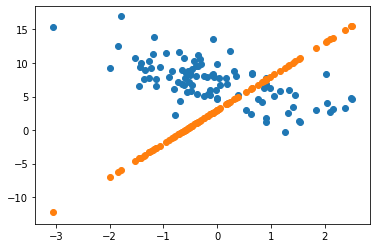

In [69]:
showYHat(yHat: denseLayerCombination(inputTensor: A, 
                                     weightParameter: weightParameter, 
                                     biasParameter: biasParameter))

In [78]:
timeTrials(trials: 300) { 
    let (activations, activationChain) = valueWithPullback(at: A, 
                                                            weightParameter,
                                                            biasParameter, 
                                                           in: denseLayerCombination)
    let (ddxActivations, _) =  pullback(at: activations, 
                                      yValidationPoints, 
                                  in: meanSquaredErrorOfTensor)(TensorFloat(1))
    let (__, ddxWeightParam, ddxBiasParam) = activationChain(ddxActivations)
    weightParameter -= learningRate * ddxWeightParam
    biasParameter -= learningRate * ddxBiasParam
}

average: 1.5709762733333335 ms,   min: 1.483593 ms,   max: 1.728663 ms


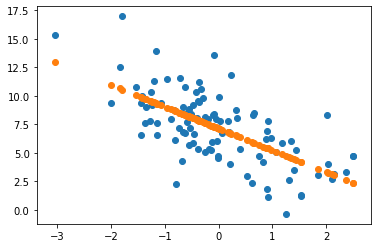

In [79]:
showYHat(yHat: denseLayerCombination(inputTensor: A, 
                                     weightParameter: weightParameter, 
                                     biasParameter: biasParameter))

In [96]:
var weightParameter = TensorFloat([5, 3]).expandingShape(at: 1)
let learningRate: Float = 5e-2
var biasParameter = TensorFloat(zeros: [1])
let tfDenseLayer = Dense(weight: weightParameter, bias: biasParameter, activation: {a in a})

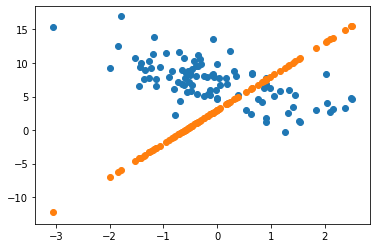

In [97]:
showYHat(yHat: tfDenseLayer(A))

In [100]:
timeTrials(trials: 300) { 
    let (activations, activationChain) = tfDenseLayer.valueWithPullback(at: A, in: tfDenseLayer)
    let (mse, gradientSupplier) = meanSquaredErrorAndGradient(yHat: activations, y: yValidationPoints)
    print(type(of: gradientSupplier))
//     let (__, ddxWeightParam, ddxBiasParam) = activationChain(gradientSupplier())
    
//     tfDenseLayer.weight -= learningRate * ddxWeightParam
//     tfDenseLayer.bias -= learningRate * ddxBiasParam
}

: 

In [ ]:
showYHat(yHat: tfDenseLayer(A))